# NASLib tutorial and intro to exercise

[NASLib](https://github.com/automl/NASLib) is framework that was built in order to facilitate neural architecture search (NAS) research and development. Please refer to the slides and to the [NAS survey paper](https://arxiv.org/abs/1808.05377) for more details. In a high-level NASLib consists of 4 main building blocks which (can) interact with each other:
- search spaces (cell search space, hierarchical, ...)
- optimizers (one-shot/weight-sharing optimizers, black-box optimizers)
- predictors (performance estimators that given an architecture as input, output its performance)
- evaluators (run the architecture search loop and the final network training pipeline)

**NOTE: NASLib is currently under development. This exercise is meant to be beneficial for both students and the NASLib developers. In case of any issues or bugs please contact us and we will try to fix those. If you are interested in working to extend the library please contact Arber.**

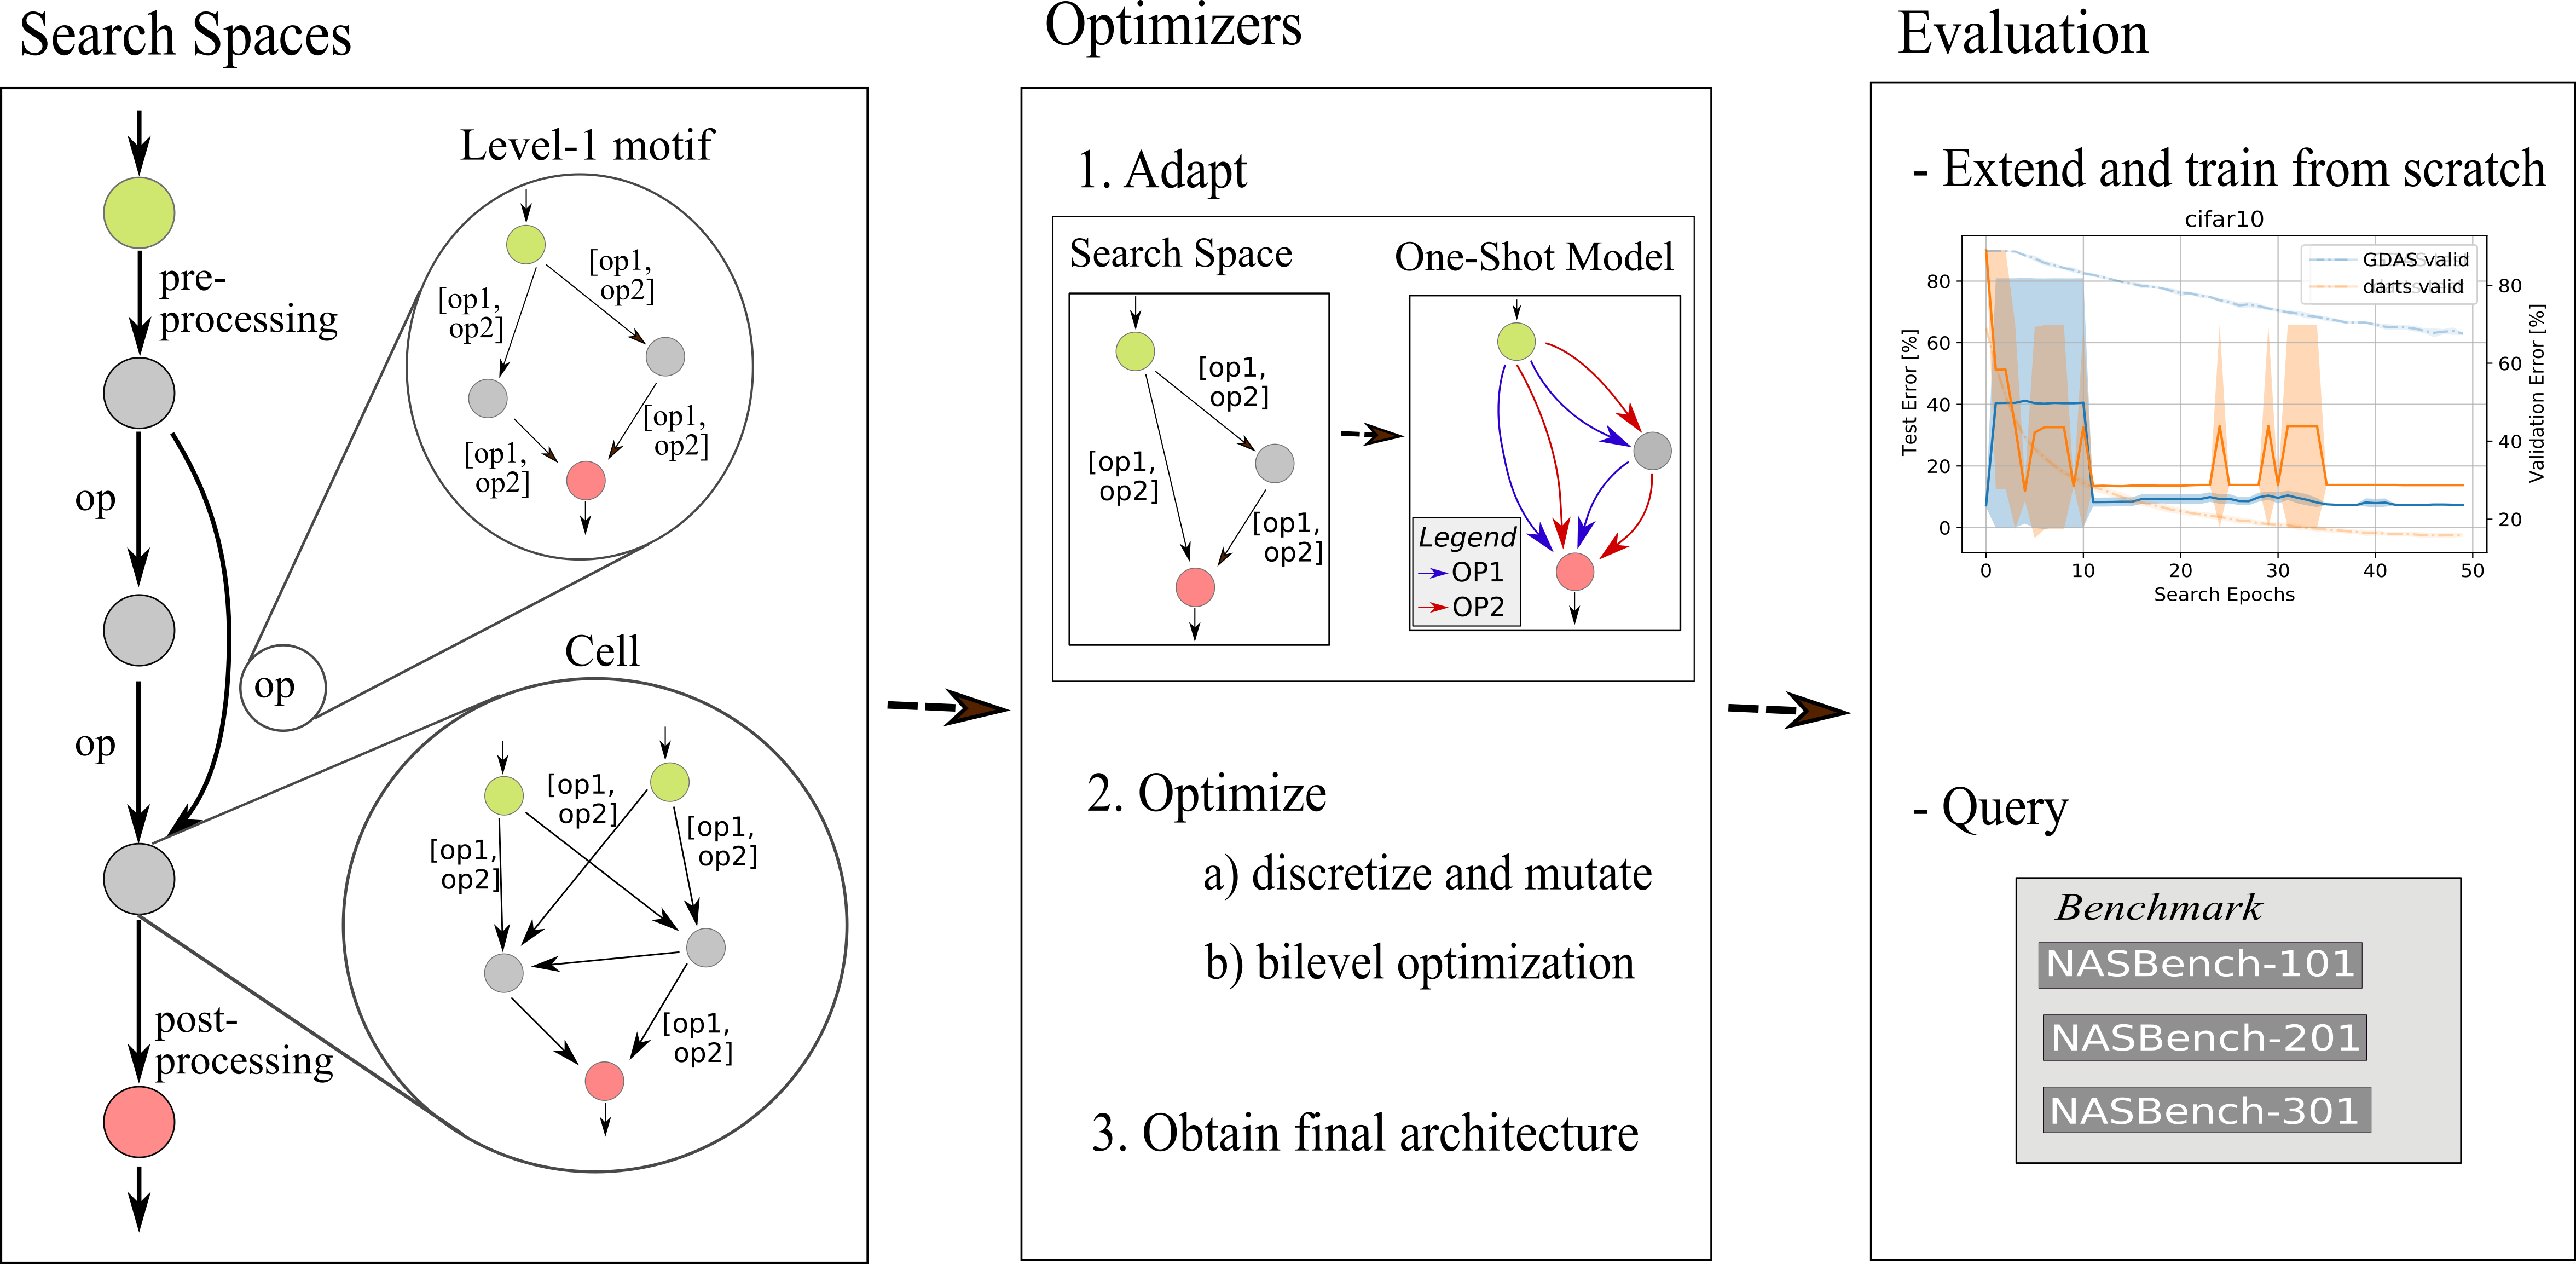

## Installation and setup 

**NOTE**: this installation is tested on a Linux machine. If you use Windows or Mac, it is recomended to use an Ubuntu virtual instance (e.g. with VirtualBox). You have to install jupyter via `pip install jupyterlab`.

Firstly, create a virtual environment and make sure to use the latest version of pip and setuptools:
```
python3 -m venv naslib-venv
source naslib-venv/bin/activate

pip install --upgrade pip setuptools wheel
pip install cython pytest
```

For this exercise we will use the **dllab21** branch of the NASLib repository. Open a new terminal and execute the following:
```
git clone https://github.com/automl/NASLib
cd NASLib
git checkout dllab21
```
Afterwards, install NASLib by running the `setup.py` file in developer mode:
```
python setup.py develop
```

In order to run this jupyter notebook using the naslib virtualenv that you just created, just execute the following in your terminal:
```
pip install ipykernel
ipython kernel install --user --name=naslib-venv
jupyter-notebook NASLib/docs/naslib_tutorial.ipynb
```
You can set the environment by `Kernel -> Change Kernel -> naslib-venv`

## Cell search spaces in NASLib 

The search space representation is of primary importance for NASLib in ensuring that optimizers and search spaces can be combined in a variety of ways. The predominant way of representing NAS search spaces is the directed acyclic graph (DAG). 
In order to accomplish the aforementioned functionality of search spaces and computational graphs, we inherit in our basic graph classes from both [PyTorch](https://pytorch.org/) and [NetworkX](https://github.com/networkx/networkx). The latter is a well-maintained and tested Python package for graph creation and manipulation, where node and edge attributes can be arbitrary Python objects. This framework allows us to represent multiple layers of graphs on top of the computational graph, allowing us to treat nodes and edges both as primitive operations (e.g. convolution), but also nested graph-structures such as a DARTS cell, to create e.g. macro architectures of stacked cells. NetworkX allows to easily construct the search space via `add_node`, `remove_node`, `add_edge`, `remove_edge`, or traverse the topologically sorted graph in the forward pass of the PyTorch module using `networkx.algorithms.dag.topological_sort`.

### Case study: NAS-Bench-201

[The NAS-Bench-201](https://openreview.net/forum?id=HJxyZkBKDr) is a tabular benchmark, i.e. a benchmark where you can simply query (already has been trained) the performance and other metrics of a specific architecture in the search space given that as an input. Its search space consists of a single normal cell which is replicated multiple times in a macro architecture interleaved by manually defined resnet-like reduction cells. The cell topology is fixed in the cell and consists of:
- 1 input, 2 intermediate and 1 output node;
- a summation operation on each of the intermediate and output nodes;
- 5 operation choices in each of the edges connecting 2 nodes
    - 'none'
    - 'skip_connect'
    - 'nor_conv_1x1'
    - 'nor_conv_3x3'
    - 'avg_pool_3x3'
    
For an example on how it this search space is defined using the NASLib language, refer to [here](https://github.com/automl/NASLib/blob/predictors/naslib/search_spaces/nasbench201/graph.py).

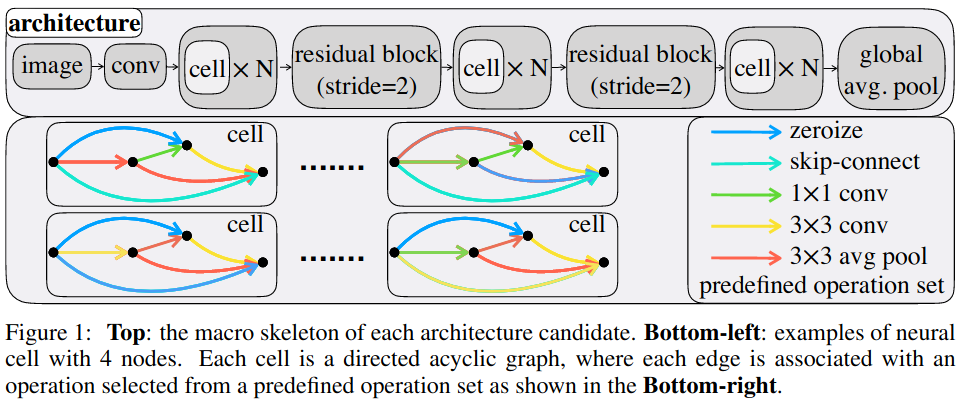

In [2]:
!export PYTHON_PATH='/home/mehtay/research/NASLib'

In [3]:
from naslib.search_spaces import NasBench201SearchSpace as NB201

# instantiate the search space object
search_space = NB201()

ModuleNotFoundError: No module named 'naslib.search_spaces.simple_cell'

## Black-box optimizers in NASLib

After learning about the search space object, now we can add the other component of NAS: the NAS optimizer which you will use to search for an optimal architecture in that search space. A search space graph object can be interpreted in different ways depending on the type of optimizer being used. Here is the point where the search space and optimizer objects interact by parsing information from each other. 

In [ ]:
# import some utilities and parse the configuration file
import logging

from naslib import utils
from naslib.utils import setup_logger, get_dataset_api

# This will read the parameters from the default yaml configuration file, which in this 
# case is located in NASLib/naslib/benchmarks/nas_predictors/discrete_config.yaml.
# You do not have to change this but you can play around with its parameters.
config = utils.get_config_from_args(config_type="nas_predictor")
utils.set_seed(config.seed)
utils.log_args(config)

logger = setup_logger(config.save + "/log.log")
logger.setLevel(logging.INFO)

In [ ]:
from naslib.optimizers import RegularizedEvolution as RE

# instantiate the optimizer object using the configuration file parameters
optimizer = RE(config)

After parsing the configuration file and instantiating the NAS optimizer and search space objects, we have to adapt the search space based on the optimizer type. 
A black-box optimizer such as Random Search will sample single architectures using the `sample_random_architecture` method of the search space object (e.g. by sampling one operation at each graph edge from the operation choices in NAS-Bench-201) throughout the optimization process.
On the other hand most one-shot optimizers, such as [DARTS](https://arxiv.org/abs/1806.09055), will interpret a set of operation choices on an edge as a `MixedOp` and assign an appropriate number of architectural weights (between 0 and 1, such that the sum is 1) to the outputs of each operation in order to obtain the continuous relaxation. 

Download the NAS-Bench-201 data from https://drive.google.com/file/d/17EBlTidimMaGrb3fE0APbljJl-ocgfs4/view?usp=sharing and place it in `NASLib/naslib/data/`.

In [ ]:
# this will load the NAS-Bench-201 data (architectures and their accuracy, runtime, etc).
dataset_api = get_dataset_api(config.search_space, config.dataset)

# adapt the search space to the optimizer type
optimizer.adapt_search_space(search_space, dataset_api=dataset_api)

## Running the search

Now the only step left is to run the search. Fro this we will use the `Trainer` object in NASLib:

In [ ]:
from naslib.defaults.trainer import Trainer

# since the optimizer has parsed the information of the search space, we do not need to pass the search
# space object to the trainer when instantiating it.
trainer = Trainer(optimizer, config, lightweight_output=True)

In [ ]:
# call only a method to run the search for the number of iterations specified in the yaml configuration file.
trainer.search()

In [ ]:
# After the search is done, we want to evaluate the test performance of
# the best architecture found using the validation set.
trainer.evaluate(dataset_api=dataset_api)

## NAS predictors

The performance predictors in NASLib are categorized in 4 classes:
- *Model-based predictors*
    - These are usually regression models (e.g. Gaussian Processes or XGBoost) that are trained with a data (x, y), where x is the architecture encoding and y is the validation performance of the trained architectures. At test time, they predict the performance of new architectures from the space.
- *Learning curve predictors*
    - These predictors estimate the architecture ranking (e.g. at epoch 100) by using the performance at a lower epoch or some other statistics. An example is early stopping. By early stopping the training at epoch 30, we hope that the ranking of the architectures will be the same as the ranking at epoch 100.
- *Zero-cost predictors*
    - These predictors usually run only a single mini-batch iteration through a sampled architecture and use some statistics (e.g. norm of gradients) in order to determine how good that architecture is.
- *One-shot predictors*
    - This class of predictors utilizes the shared weights of the one-shot model in order to rank the architectures based on the validation performance using these shared weights.
    
In NASLib we have implemented **31 predictors** that can be easily imported and evaluated on the tabular benchmarks. Check also this file for some more details: https://github.com/automl/NASLib/blob/master/docs/predictors.md and our paper: https://arxiv.org/abs/2104.01177

In [ ]:
# Load the predictor evaluator and the predictor (XGBoost in this case)
from naslib.defaults.predictor_evaluator import PredictorEvaluator
from naslib.predictors import XGBoost

# read the new configuration file that has the parameters of the predictor model
# NOTE: it is important to set config_type="predictor" here
config = utils.get_config_from_args(args=["--config-file", "naslib/benchmarks/predictor_config.yaml"], 
                                    config_type="predictor")
utils.set_seed(config.seed)
utils.log_args(config)

logger = setup_logger(config.save + "/log.log")
logger.setLevel(logging.INFO)

# Now instantiate the predictor (every predictor works with certain encoding types for the architecture)
predictor = XGBoost(encoding_type='adjacency_one_hot', hpo_wrapper=False)
# Instantiate the evaluator
predictor_evaluator = PredictorEvaluator(predictor, config=config)
# similarly to the conventional NAS search that we saw before, the predictor evaluator also adapts to 
# the search space at hand
predictor_evaluator.adapt_search_space(search_space, load_labeled=False, 
                                       dataset_api=dataset_api)
# No search in this case. We only train the predictor on the training data and evaluate it on the test data.
# Note that the training data here is the pair (arch, performance) and not (image, label).
predictor_evaluator.evaluate()

The stdout shows some metrics such as the rank correlation (Spearman or Kendall Tau) of 100 sampled architectures from the test set. This shows how good the ranking of the architectures based on the performance predictor is compared to the true ranking from NAS-Bench-201.

## Using the predictors as surrogate models in Bayesian Optimization

In order to use the aforementioned predictors as surrogate models inside Bayesian Optimization, we need to have a mean prediction and uncertainty estimates for every architecture. Some of the models (e.g. GPs) already provide this, but for some others such as MLPs we construct an ensemble of MLPs in order to obtain the uncertainty estimates.

This code snippet shows how to run [BANANAS](https://arxiv.org/abs/1910.11858) with some of the performance predictors as surrogate models. We will do 3 trials with 3 different seeds of BANANAS for 300 iterations. For this we need to firstly generate the configuration files. The bash commands below do this. 

In [ ]:
%%bash
optimizer=bananas
predictors=(mlp lgb xgb rf bayes_lin_reg gp)

start_seed=0

# folders:
# this supposes your location is at NASLib/docs. Change the base_file location based on where you
# opened the notebook
base_file=../naslib
save_dir=bananas_run
out_dir=$save_dir\_$start_seed

# search space / data:
search_space=nasbench201
dataset=cifar10
search_epochs=300

# trials / seeds:
trials=3
end_seed=$(($start_seed + $trials - 1))

# create config files
for i in $(seq 0 $((${#predictors[@]}-1)) )
do
    predictor=${predictors[$i]}
    python $base_file/benchmarks/create_configs.py --predictor $predictor \
    --epochs $search_epochs --start_seed $start_seed --trials $trials \
    --out_dir $out_dir --dataset=$dataset --config_type nas_predictor \
    --search_space $search_space --optimizer $optimizer
done

Similarly to how we ran RE before, write a function that gets a configuration file and optimizer as input and runs them.

In [ ]:
from naslib.optimizers import Bananas

def run_optimizer(config_file="bananas_run_0/cifar10/configs/nas_predictors/config_bananas_gp_0.yaml",
                  nas_optimizer=Bananas) -> None:
    # TODO: add all the utilities, such as config file reading, logging as before.
    # afterwards instantiate the search space, optimizer, trainer and run the search + evaluation
    pass

In [ ]:
run_optimizer()

# TASK: Implement a Regularized Evolution version that uses the performance predictors as surrogate models during the search

The Regularized Evolution (RE) code that we ran above uses the true validation performance as queried from NAS-Bench-201. Using the tabular benchmark this is certainly cheap since we are only simulating the true run. However, in real world scenarios these tabular entries are not available so we have to train every sampled/mutated architecture from scratch. This is the most expensive step in black-box optimization for NAS.

The NAS performance predictors can drastically accelerate the search by utilizing the performance as predicted by the surrogate model (performance predictor). In this exercise you will have to implement a RE version that utilizes the performance predictors to estimate the performance of the sampled architectures instead of querying that from the tabular benchmark. Sample the very first architectures in the population and query those from NB201. Then fit the performance predictor. Afterwards, every 10 iterations query again the performance from NB201 and refit the predictor. In between, however, use the performance returned by the predictor inside RE.

HINT: Check how the performance predictors are utilized inside the BANANAS implementation in NASLib.

In [ ]:
class RE_predictor(RE):
    def __init__(self, config):
        # you probably would need to add some more attributes to the __init__ method
        return NotImplementedError
    
    def new_epoch(self, epoch):
        # This is the main method that you have to override in order to add the performance predictors
        return NotImplementedError
    

Now generate the new yaml configuration files using the bash commands as shown above. Just change "bananas" to "re".

In [ ]:
#TODO: Run the RE_predictor optimizer

# for config_file in list_of_config_files:
#    run_optimizer(config_file=config_file, nas_optimizer=RE_predictor)

### Plotting the results

The results should have been written to `re_run_0/cifar10/nas_predictors/nasbench201`. Use the other jupyter notebook located in `NASLib/naslib/docs/plot.ipynb` to generate the plots based on these results.